# Code for protein sequence alignment
Returns a PNG showing similarities

In [24]:
# Defining colors for each protein residue
def get_colors_protein(seqs):
    """Make colors for bases in sequence

    Args:
        seqs (list, str): List or string with protein sequence

    Returns:
        list: List with colors
    """
    text = [i for s in list(seqs) for i in s]
    aa_colors = {
    'A': 'red',    # Alanine
    'R': 'blue',   # Arginine
    'N': 'green',  # Asparagine
    'D': 'yellow', # Aspartic acid
    'C': 'orange', # Cysteine
    'Q': 'purple', # Glutamine
    'E': 'cyan',   # Glutamic acid
    'G': 'magenta',# Glycine
    'H': 'pink',   # Histidine
    'I': 'brown',  # Isoleucine
    'L': 'gray',   # Leucine
    'K': 'lime',   # Lysine
    'M': 'teal',   # Methionine
    'F': 'navy',   # Phenylalanine
    'P': 'olive',  # Proline
    'S': 'maroon', # Serine
    'T': 'silver', # Threonine
    'W': 'gold',   # Tryptophan
    'Y': 'skyblue',# Tyrosine
    'V': 'violet', # Valine
    '-':'white'
    }
    colors = [aa_colors[i] for i in text]
    return colors

# Bokeh sequence plotter
Code using the Bokeh-panel strategy

In [25]:
import numpy as np

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot

In [32]:
def view_alignment(aln, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view
    From: https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner"""
    # The function takes a biopython alignment object as input.
    # rec is the alignment record: Each one of the entries given as input
    seqs = [rec.seq for rec in (aln)] # Each sequence input
    ids = [rec.id for rec in aln] # Each entry ID
    text = [i for s in list(seqs) for i in s] #Al units joind on same list
    # List with ALL colors
    colors = get_colors_protein(seqs)    
    N = len(seqs[0]) # What if they're not the same length???
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5 # Just to make the rectangles twice the size and the letter in the middle
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    print(f'Aligning {S} sequences of lenght {N}')
    # ColumnDataSource is a JSON dict that maps names to arrays of values
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0, N+1, bounds='auto') # (start, end)
    if N>150:
        viewlen=150
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #entire sequence view (no text, with zoom)
    p = figure(title=None, width=plot_width, height=50,
               x_range=x_range, y_range=(0,S), tools=tools,
               min_border=0, toolbar_location='below')
    # Rect simply places rectangles of wifth "width" into the positions defined by x and y
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                 line_color=None, fill_alpha=0.6)
    # Source does mapping from keys in rects to values in ColumnDataSource definition
    p.add_glyph(source, rects) 
    p.yaxis.visible = False
    p.grid.visible = False  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, width=plot_width, height=50,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)   
    # Text does the same thing as rectangles but placing letter (or words) instead, aligned accordingly   
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = True
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p

In [33]:
# Note here: The aminoacid sequences must be the same length, with missing units represented as '-'
aln = AlignIO.read('covid_edit.aln','fasta')
p = view_alignment(aln, plot_width=1500)
pn.pane.Bokeh(p)

Aligning 2 sequences of lenght 301


BokehModel(combine_events=True, render_bundle={'docs_json': {'0590f438-8ab2-4df4-ad72-74ac0e1c0558': {'version…

# Implementation with Matplotlib 

In [34]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

In [35]:
def view_alignment(aln, fontsize=9, plot_height=1, plot_width=10, img_file="alignment.png"):
    """Create PNG file with sequence alignment
    Args:
        aln (AlignIO object): Biopython alignment object with sequences
        fontsize (int, optional): Font size of Amino acid letters
        plot_height (int, optional): Plot height.
        plot_width (int, optional): Plot width.

    Returns:
        _type_: _description_
    """
    # The function takes a biopython alignment object as input.
    # rec is the alignment record: Each one of the entries given as input
    seqs = [rec.seq for rec in (aln)] # Each sequence input
    ids = [rec.id for rec in aln] # Each entry ID
    print(ids)
    text = [i for s in list(seqs) for i in s] #Al units joind on same list
    # List with ALL colors
    colors = get_colors_protein(seqs)    
    N = len(seqs[0]) # What if they're not the same length???
    S = len(seqs)    
    print(f'Aligning {S} sequences of lenght {N}')
    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    # Rectangles have to be defined at an offset
    rectx = gx - 0.5
    recty = gy - 0.5 
    # Heigth and width
    w = 1
    h = 1
    rectangles = [(x, y, facecolor, id) for x, y, facecolor, id in zip(rectx, recty, colors, text)]
    if N>150:
        viewlen=150
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)

    # Defining the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(plot_width, plot_height))

    # Top plot (label-less)
    ax1.plot([rectx[0], N+1],[recty[0], recty[-1]], lw=0)
    for x, y, facecolor, id in rectangles:
        rect = Rectangle((x, y), w, h, facecolor=facecolor,
                         edgecolor='black', fill=True, lw=0.0, alpha=0.6)
        ax1.add_patch(rect)
    ax1.set_yticks([])   
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim(rectx[0], rectx[-1]+1,)
    
    # Bottom plot
    ax2.plot([rectx[0], N+1],[recty[0], recty[-1]], lw=0)
    # Adding rectagle to the axis one by one: O(n)
    for x, y, facecolor, id in rectangles:
        rect = Rectangle((x, y), w, h, facecolor=facecolor,
                         edgecolor='black', fill=True, lw=0.1, alpha=0.6)
        ax2.add_patch(rect)
        # Adding the aminoacid identifier
        ax2.text(x+0.5, y+0.5, id, fontsize=fontsize, ha='center', va='center')    
        
    ax2.set_yticks(range(0,S)) 
    ax2.set_yticklabels(ids)  
    ax2.set_xticks(range(0,N+1)) 
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim(rectx[0], rectx[-1]+1,)

    fig.savefig(img_file)

    return fig, ax1, ax2

The MERS-CoV data

['MERS-CoV', 'SARS-CoV-2']
Aligning 2 sequences of lenght 301


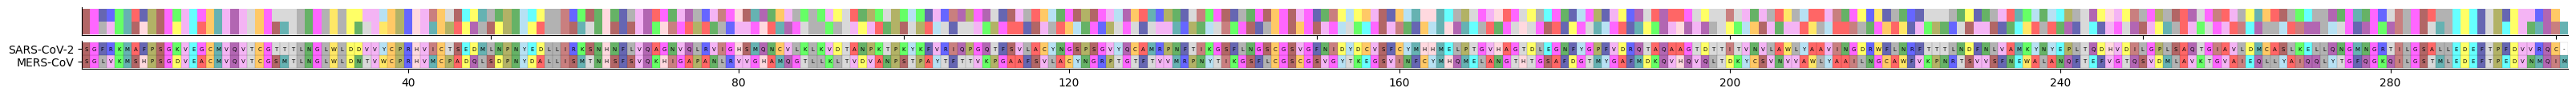

In [36]:
aln = AlignIO.read('covid_edit.aln','fasta') # manually edited sequences
fig, ax1, ax2 = view_alignment(aln, plot_height=1, plot_width=40, fontsize=5)
plt.show()


## Implementation with Matplotlib and without BioPython

Implementing a sequence reader class

In [37]:
class Seq_reader():

    def __init__(self, seq, format='list'):
        """Read the sequences for alignment as a file or list, and returns data

        Args:
            seq (str, list, numpy ndarray): The alignment sequences as a list of lists or tuples,
                                            (seq id, seq)
            format (str): Format of the input: {list, fasta}
        """

        if format == 'list':
            if isinstance(seq, list) or isinstance(seq, np.ndarray):
                if len(seq[0])==2 and isinstance(seq[0][0], str):
                    self.ids = [s[0] for s in seq]
                    self.ids = [s[1] for s in seq]
                else: 
                    raise ValueError("The format of each sequence must be a list/tuple (seqID, seq)")
            else:
                raise ValueError("Format 'list' only takes a list or np.ndarray, please specify the correct format")
        elif format == 'fasta':
            if isinstance(seq, str):
                self.seqs, self.ids = self.read_fasta(seq)
            else:
                raise ValueError("'fasta' format takes a sequence file, please specify the correct format")

        else:
            raise NotImplementedError("Only list and fasta inputs are implemented...for now")
        
        # Adjust sequence length
        self.seqs = self.adjust_length()
        
    def read_fasta(self, file):
        """Read a valid fasta file

        Args:
            file (str): Fasta file
        """
        seqs = []
        ids = []
        start = -1
        with open(file, 'r') as f:
            for i, line in enumerate(f):
                if line[0] == ">":
                    start = i
                    label = line[1:].split()
                    ids.append(label[0])
                if start>-1 and i==start+1:
                    seqs.append(line.strip())
        if start < 0:
            raise RuntimeError("No sequences were read in the file. Make sure each label is initialized with '>'")
        else:
            return seqs, ids 
    
    def adjust_length(self):
        """If the sequences have different length, pads on the right the missing sequences

        Returns:
            list: Adjusted strings
        """
        # Get the length of the longest seq string
        longest =  max(len(s) for s in self.seqs)

        # Adjust all strings to have the same length
        adjusted_strings = [s.ljust(longest, '-') for s in self.seqs]
        return adjusted_strings  

In [38]:
def view_alignment(seq, fontsize=9, plot_height=1, plot_width=10, img_file="alignment.png"):
    """Implementation of alignment function, that returns a png with the alignment view

    Args:
        seq (Seq_reader): Object with sequences info
        fontsize (int, optional): Printing font of aminoacids. Defaults to 9.
        plot_height (int, optional): Plot height. Defaults to 1.
        plot_width (int, optional): Plot width. Defaults to 10.
        img_file (str, optional): Name of the image file with the final alignment.

    Returns:
        fig, ax1, ax2
    """
    seqs = seq.seqs # Each sequence input
    ids = seq.ids # Each entry ID
    print(ids)
    text = [i for s in list(seqs) for i in s] #Al units joined on same list
    # List with ALL colors
    colors = get_colors_protein(seqs)    
    N = len(seqs[0]) # What if they're not the same length???
    S = len(seqs)    
    print(f'Aligning {S} sequences of lenght {N}')
    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    # Rectangles have to be defined at an offset
    rectx = gx - 0.5
    recty = gy - 0.5 
    # Heigth and width
    w = 1
    h = 1
    rectangles = [(x, y, facecolor, id) for x, y, facecolor, id in zip(rectx, recty, colors, text)]

    # Defining the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(plot_width, plot_height))

    # Top plot (label-less)
    ax1.plot([rectx[0], N+1],[recty[0], recty[-1]], lw=0)
    for x, y, facecolor, id in rectangles:
        rect = Rectangle((x, y), w, h, facecolor=facecolor,
                         edgecolor='black', fill=True, lw=0.0, alpha=0.6)
        ax1.add_patch(rect)
    ax1.set_yticks([])   
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim(rectx[0], rectx[-1]+1,)
    
    # Bottom plot
    ax2.plot([rectx[0], N+1],[recty[0], recty[-1]], lw=0)
    # Adding rectagle to the axis one by one: O(n)
    for x, y, facecolor, id in rectangles:
        rect = Rectangle((x, y), w, h, facecolor=facecolor,
                         edgecolor='black', fill=True, lw=0.1, alpha=0.6)
        ax2.add_patch(rect)
        # Adding the aminoacid identifier
        ax2.text(x+0.5, y+0.5, id, fontsize=fontsize, ha='center', va='center')    
        
    ax2.set_yticks(range(0,S)) 
    ax2.set_yticklabels(ids)  
    ax2.set_xticks(range(0,N+1)) 
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim(rectx[0], rectx[-1]+1,)

    fig.savefig(img_file)

    return fig, ax1, ax2

This version of the code corrects for sequences with different lengths by padding to the left

['MERS-CoV', 'SARS-CoV-2']
Aligning 2 sequences of lenght 301


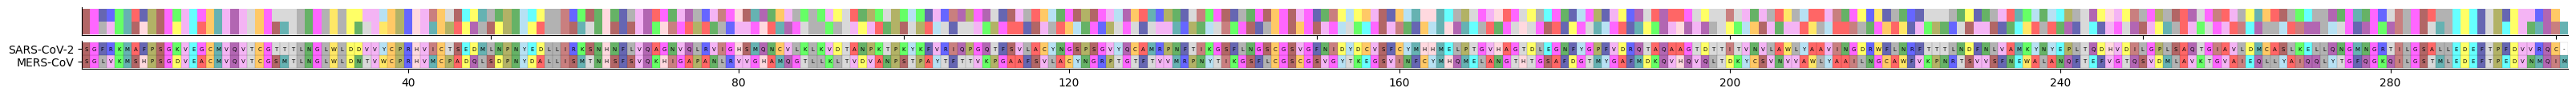

In [39]:
aln = Seq_reader('covid.aln','fasta')
fig, ax1, ax2 = view_alignment(aln, plot_height=1, plot_width=40, fontsize=5, img_file="CoV-Mpro_align.png")
plt.show()